In [41]:
import numpy as np # linear algebra
import pandas as pd
import os
import cv2
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
# import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

In [33]:
df = pd.read_csv('D:/Datasets/BrainTumor2/Brain Tumor/Brain Tumor.csv')
df.Class = df["Class"].map({1:"Tumor", 0:"Normal"})
df.Image += ".jpg"
df.head()

,Image,Class,Mean,Variance,Standard Deviation,Entropy,Skewness,Kurtosis,Contrast,Energy,ASM,Homogeneity,Dissimilarity,Correlation,Coarseness
0,Image1.jpg,Normal,6.535339,619.587845,24.891522,0.109059,4.276477,18.900575,98.613971,0.293314,0.086033,0.530941,4.473346,0.981939,7.460000e-155
1,Image2.jpg,Normal,8.749969,805.957634,28.389393,0.266538,3.718116,14.464618,63.858816,0.475051,0.225674,0.651352,3.220072,0.988834,7.460000e-155
2,Image3.jpg,Tumor,7.341095,1143.808219,33.820234,0.001467,5.061750,26.479563,81.867206,0.031917,0.001019,0.268275,5.981800,0.978014,7.460000e-155
3,Image4.jpg,Tumor,5.958145,959.711985,30.979219,0.001477,5.677977,33.428845,151.229741,0.032024,0.001026,0.243851,7.700919,0.964189,7.460000e-155
4,Image5.jpg,Normal,7.315231,729.540579,27.010009,0.146761,4.283221,19.079108,174.988756,0.343849,0.118232,0.501140,6.834689,0.972789,7.460000e-155


In [10]:
import cv2
classes =[]
images= []
path = 'D:/Datasets/BrainTumor2/Brain Tumor/Brain Tumor/'
files = os.listdir(path)

for i, fle in enumerate(files):
    fileName = fle.split('.')[0]
    status = df[df['Image']== fileName]['Class'].to_numpy()
    classes.append(status)
    total = path + fle
    image= cv2.imread(total)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image= cv2.resize(image,(240,240))
    images.append(image)

In [11]:
images_f=np.array(images, dtype = np.float64)
classes_f=np.squeeze(np.array(classes, dtype = np.float64))
del images, classes
images_f.shape

(3762, 240, 240, 3)

The label is: 0.0


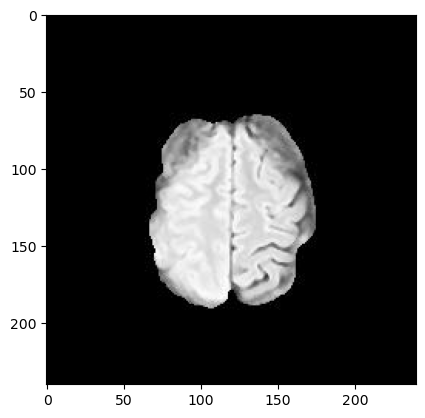

In [ ]:
i = 234
plt.imshow(images_f[i]/255.0, cmap = 'bone')
print(f'The label is: {classes_f[i]}')

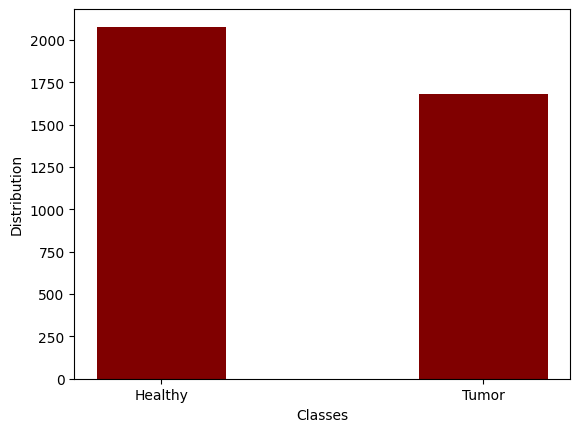

In [ ]:
values, counts = np.unique(classes_f, return_counts=True)
plt.bar(values, counts, color ='maroon',
        width = 0.4)
plt.xticks([0, 1], ['Healthy', 'Tumor'])
plt.xlabel('Classes')
plt.ylabel('Distribution')
plt.show()

In [34]:
clss = np.squeeze(classes_f)
threshold = 3200                    # Threshold of data split
ds = pd.DataFrame({                  # Defining dataframe for training and validation
    'file_name': df.Image.iloc[:threshold],
    'class': df.Class.iloc[:threshold]
})

dt = pd.DataFrame({                  # Defining dataframe for testing 
    'file_name': df.Image.iloc[threshold:],
    'class': df.Class.iloc[threshold:]
})
dt['class'].value_counts()

Tumor     358
Normal    204
Name: class, dtype: int64

In [48]:
def evaluate_model(model1, dataframe = dt, directory = path):
    # Now we shall test the model with a previously seperated chunk of data
    test_datagen = ImageDataGenerator(rescale=1 / 255.0,
                                     dtype = 'float64')
    final_test_data = test_datagen.flow_from_dataframe(
        dataframe = dataframe,
        directory= path,
        x_col="file_name", 
        y_col="class",
        class_mode="binary",
        shuffle = False,
        target_size=(240,240),
        seed=4,
        )
    y_true = dataframe['class'].map({"Normal":0, "Tumor":1}).to_numpy()
    y_pred = np.round(model1.predict(final_test_data, verbose = 2))
    test_loss, test_acc = model1.evaluate(final_test_data, verbose=2)
    print(metrics.classification_report(y_true, y_pred))
    return test_loss, test_acc

In [49]:
model2 = keras.models.load_model(r"my_best_model.epoch60-Loss0.0802.hdf5")
test_loss, test_acc = evaluate_model(model2)

Found 562 validated image filenames belonging to 2 classes.
18/18 - 7s - 7s/epoch - 410ms/step
18/18 - 7s - loss: 0.0698 - binary_accuracy: 0.9733 - 7s/epoch - 394ms/step
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       204
           1       0.99      0.97      0.98       358

    accuracy                           0.97       562
   macro avg       0.97      0.97      0.97       562
weighted avg       0.97      0.97      0.97       562



Found 562 validated image filenames belonging to 2 classes.
18/18 - 12s - 12s/epoch - 682ms/step


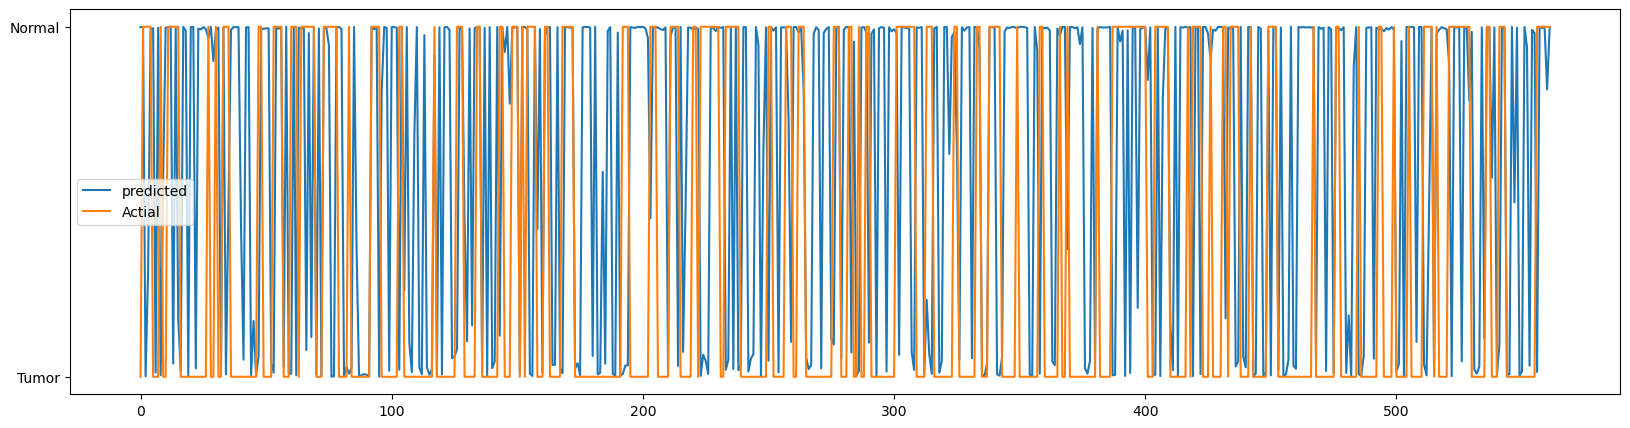

In [80]:
test_datagen = ImageDataGenerator(rescale=1 / 255.0,
                                    dtype = 'float64')
final_test_data = test_datagen.flow_from_dataframe(
    dataframe = dt,
    directory= path,
    x_col="file_name", 
    y_col="class",
    #we are doing regression, so we will assign class_mode to 'raw'
    class_mode="binary",
    #to convert all images to same pixel size, for neural networks, all images should have similar size
    target_size=(240,240),
    seed=4,
    )
y_true = dt['class'].to_numpy()
y_pred = model2.predict(final_test_data, verbose = 2)
fig = plt.figure(figsize=(20, 5))
plt.plot(y_pred, label = "predicted")
plt.plot(y_true, label = "Actial")
plt.legend()

In [40]:
print(f'So here we are getting test accuracy of {test_acc*100} %, which is descent for such simple CNN model.')

So here we are getting test accuracy of 97.33096361160278 %, which is descent for such simple CNN model.


Found 562 validated image filenames belonging to 2 classes.


Classes: 1 => Tumor, 0 => No-Tumor


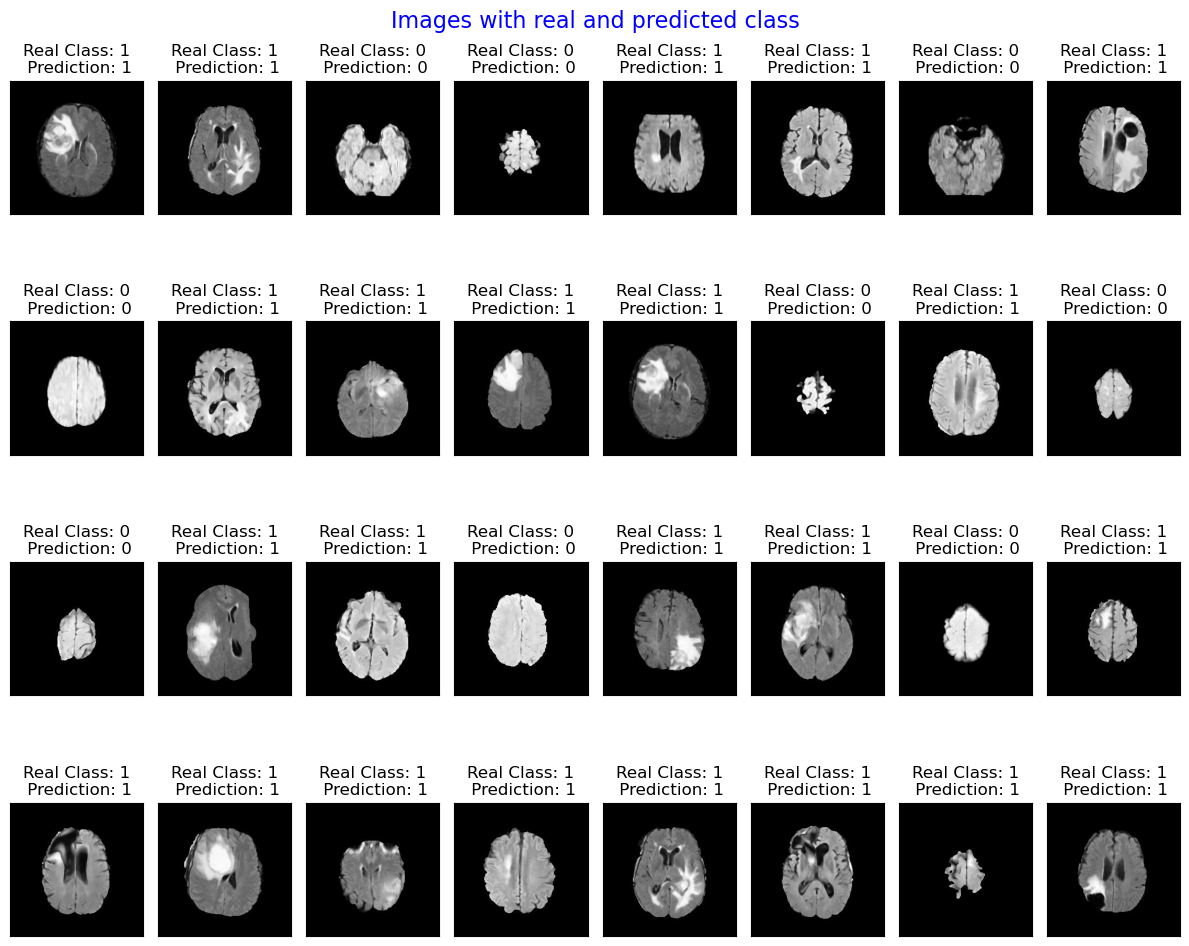

In [53]:
test_datagen = ImageDataGenerator(rescale=1 / 255.0,
                                     dtype = 'float64')
final_test_data = test_datagen.flow_from_dataframe(
    dataframe = dt,
    directory= path,
    x_col="file_name", 
    y_col="class",
    #we are doing regression, so we will assign class_mode to 'raw'
    class_mode="binary",
    #to convert all images to same pixel size, for neural networks, all images should have similar size
    target_size=(240,240),
    seed=4,
    )
#get one batch from our datagenerator and display images in it
features, target = next(final_test_data)
# display 32 images
fig = plt.figure(figsize=(12,12))
for i in range(32):
    fig.add_subplot(4, 8, i+1)
    plt.imshow(features[i])
    plt.title(f'Real Class: {int(target[i])}\n Prediction: {int(np.round(model2.predict(np.expand_dims(features[i], axis = 0),verbose = 0)[0][0]))}')
# remove axes and place the images closer to one another for a more compact output
    plt.xticks([])
    plt.yticks([])
    plt.suptitle('Images with real and predicted class',  y=0.9,fontsize=16, color='b')
    plt.tight_layout()
print(f'Classes: 1 => Tumor, 0 => No-Tumor')

In [54]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 240, 240, 32)      2432      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 120, 120, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 120, 120, 64)      18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 60, 60, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 60, 60, 96)        55392     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 30, 30, 96)      

In [55]:
from tensorflow.keras.models import Model
ft_input = model2.input
ft_layers = model2.layers
features = Model(inputs = ft_input, outputs = ft_layers[-4].output)
features.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 conv2d_15 (Conv2D)          (None, 240, 240, 32)      2432      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 120, 120, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 120, 120, 64)      18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 60, 60, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 60, 60, 96)        55392 

In [56]:
from tqdm import tqdm
image_features = []
n = len(ds)
for i in tqdm(range(n)):
    temp = np.array(images_f[i], dtype = np.float64)/255.0
    temp = np.expand_dims(temp, axis = 0)
    feat = features.predict(temp, verbose = 0)
    image_features.append(feat)

del images_f
image_features = np.array(image_features)
image_features.shape

100%|██████████| 3200/3200 [04:45<00:00, 11.19it/s]


(3200, 1, 32)

In [57]:
y = np.squeeze(classes_f[:n])
image_features = np.squeeze(image_features)
image_features.shape, y.shape

((3200, 32), (3200,))

In [58]:
!pip install lightgbm optuna

In [59]:
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgbm
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score
import optuna

### With LightGBM

In [61]:
lgbm_params = 
{'learning_rate': 0.016305696769506942,
 'n_estimators': 800,
 'lambda_l1': 0.0018433685757398184,
 'lambda_l2': 0.0022098737089695656,
 'num_leaves': 174,
 'feature_fraction': 0.9827401596113596,
 'bagging_fraction': 0.724695129984146,
 'bagging_freq': 5,
 'min_child_samples': 79}
 

In [62]:
X_train, X_temp, y_train, y_temp = train_test_split(image_features, y, test_size=0.3)
model_classifier = lgbm.LGBMClassifier(**lgbm_params) 
model_classifier.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_cv = model_classifier.predict(X_temp)
# Calculate accuracy
accuracy = accuracy_score(y_temp, y_pred_cv)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_temp, y_pred_cv))

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_temp, y_pred_cv)
print("ROC-AUC Score:", roc_auc)

[LightGBM] [Warning] feature_fraction is set=0.9827401596113596, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9827401596113596
[LightGBM] [Warning] lambda_l1 is set=0.0018433685757398184, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0018433685757398184
[LightGBM] [Warning] lambda_l2 is set=0.0022098737089695656, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0022098737089695656
[LightGBM] [Warning] bagging_fraction is set=0.724695129984146, subsample=1.0 will be ignored. Current value: bagging_fraction=0.724695129984146
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9827401596113596, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9827401596113596
[LightGBM] [Warning] lambda_l1 is set=0.0018433685757398184, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0018433685757398184
[LightGBM] [Warning] 

We can tune it further using optuna...

In [ ]:
def objective(trial):
    dtrain = lgbm.Dataset(X_train, label=y_train)

    param = {
        "objective": "binary",
        'device': 'gpu',
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        'learning_rate':trial.suggest_float("learning_rate", 1e-8, 0.5, log=True),
        "n_estimators" : trial.suggest_int('n_estimators', 100, 1600,10),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    gbm = lgbm.train(param, dtrain)
    preds = gbm.predict(X_temp)
    pred_labels = np.rint(preds)
    score = f1_score(y_temp, pred_labels)
    return score



study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=400)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
lgbm1_params = study.best_params

### With Random Forest

In [19]:
model_classifier = RandomForestClassifier()
model_classifier.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_cv = model_classifier.predict(X_temp)
# Calculate accuracy
accuracy = accuracy_score(y_temp, y_pred_cv)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_temp, y_pred_cv))

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_temp, y_pred_cv)
print("ROC-AUC Score:", roc_auc)

Accuracy: 0.9802083333333333
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       484
         1.0       0.99      0.97      0.98       476

    accuracy                           0.98       960
   macro avg       0.98      0.98      0.98       960
weighted avg       0.98      0.98      0.98       960

ROC-AUC Score: 0.9801635530245156


# Now let LGBM be our final classifier model

In [77]:
model_classifier = lgbm.LGBMClassifier(**lgbm_params, verbose = -1)
model_classifier.fit(image_features, y)

LGBMClassifier(bagging_fraction=0.724695129984146, bagging_freq=5,
               feature_fraction=0.9827401596113596,
               lambda_l1=0.0018433685757398184, lambda_l2=0.0022098737089695656,
               learning_rate=0.016305696769506942, min_child_samples=79,
               n_estimators=800, num_leaves=174, verbose=-1)

In [81]:
def evaluate_hybrid_model(feature_model, classifier_model, dataframe = dt.reset_index(drop = True), directory = path):
    # Now we shall test the model with a previously seperated chunk of data
    n = len(dataframe)
    y_pred = []
    for i in tqdm(range(n)):
        fileName = dataframe['file_name'][i]
        total = path + fileName
        image= cv2.imread(total)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image= cv2.resize(image,(240,240))
        image = np.array(image, dtype = np.float64)/255.0
        image = np.expand_dims(image, axis = 0)
        feature = feature_model.predict(image, verbose=0)
        pred = classifier_model.predict(feature)
        y_pred.append(pred)
    y_pred = np.squeeze(np.array(y_pred))
    y_gt = np.squeeze(dataframe['class'].map({"Normal":0, "Tumor":1}).to_numpy())
    
    # Calculate accuracy
    accuracy = accuracy_score(y_gt, y_pred)
    print("Accuracy:", accuracy)

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_gt, y_pred))

    # Calculate ROC-AUC score
    roc_auc = roc_auc_score(y_gt, y_pred)
    print("ROC-AUC Score:", roc_auc)


In [82]:
evaluate_hybrid_model(features, model_classifier)

100%|██████████| 562/562 [00:56<00:00,  9.86it/s]

Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       204
           1       1.00      1.00      1.00       358

    accuracy                           1.00       562
   macro avg       1.00      1.00      1.00       562
weighted avg       1.00      1.00      1.00       562

ROC-AUC Score: 1.0
